# Team Based Model

## Imports

In [404]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import xgboost as xgb


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [405]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [406]:
team_data = load_team_data()

In [407]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)

In [408]:
clean_team_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,HOME_GAME
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,0,240,34,74,0.459,2,9,0.222,28,40,0.700,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,0.529,1.00,14.1,0.289,0.667,0.478,18.256,18.9,0.473,0.535,1.0,0.197,98.32,95.5,79.58,95.0,0.446,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.563,0.438,0.000,1.000,0.529,0.471,1
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,1,240,43,88,0.489,6,11,0.545,14,16,0.875,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,0.674,1.81,20.7,0.333,0.711,0.522,16.320,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96.0,0.554,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.622,0.378,1.000,0.000,0.674,0.326,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276,0.698,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.750,0.250,1.000,0.000,0.774,0.226,1
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302,0.724,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.467,0.533,1.000,0.000,0.500,0.500,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,240,36,80,0.450,4,17,0.235,9,13,0.692,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,0.528,1.12,15.6,0.239,NaN,NaN,18.139,18.1,0.475,0.496,1.0,0.199,93.06,94.0,78.33,94.0,0.359,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.469,0.531,1.000,0.000,0.528,0.472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,1,240,35,79,0.443,14,39,0.359,18,21,0.857,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,0.714,1.67,19.5,0.289,0.783,0.538,16.088,16.3,0.532,0.578,1.0,0.200,93.84,92.0,76.67,92.0,0.559,0.506,0.494,0.412,0.078,0.412,0.069,0.176,0.186,0.333,0.619,0.381,0.857,0.143,0.714,0.286,0
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,1,240,38,83,0.458,14,33,0.424,21,22,0.955,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,0.684,2.00,19.7,0.267,0.667,0.467,13.446,14.0,0.542,0.599,1.0,0.199,95.46,93.5,77.92,93.0,0.512,0.602,0.398,0.432,0.144,0.378,0.036,0.189,0.180,0.288,0.542,0.458,0.929,0.071,0.684,0.316,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,0,240,38,82,0.463,14,38,0.368,18,21,0.857,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,0.553,1.40,16.5,0.333,0.733,0.533,15.917,16.0,0.549,0.592,1.0,0.200,95.46,93.5,77.92,94.0,0.488,0.537,0.463,0.444,0.056,0.389,0.231,0.167,0.130,0.389,0.458,0.542,0.714,0.286,0.553,0.447,1
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,0,240,35,79,0.443,10,28,0.357,13,22,0.591,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-

In [409]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)

In [410]:
from src.data import make_team_dataset

matchups = make_team_dataset.create_matchups(ready_for_agg_df)

matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102678,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0
102681,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0,2019-20,42019,

In [429]:
from src.data.make_team_dataset import get_team_and_opp_avg
avg_data = get_team_and_opp_avg(matchups)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]


In [196]:
away_teams

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
182,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,2000-01,22000,1610612745,HOU,Houston Rockets,20000095,2000-11-11,HOU @ POR,0,-23,0,240.0,0.500000,26.666667,58.666667,5.666667,15.666667,22.166667,28.500000,11.500000,27.0,38.500000,19.666667,8.333333,3.833333,17.333333,21.333333,92.500000,3.833333,99.75,102.066667,97.100000,97.433333,2.633333,4.616667,90.5,0.524667,18.000000,8.000000,19.000000,34.500000,14.666667,11.333333,4.666667,0.833333,240.0,0.500000,29.166667,61.500000,4.666667,12.333333,16.333333,22.333333,9.666667,28.166667,37.833333,19.333333,6.333333,3.833333,17.166667,23.166667,88.666667,-3.833333,97.100000,97.433333,99.75,102.066667,-2.633333,-4.616667,90.833333,0.475333,23.5,7.500000,17.000000,34.000000,14.833333,13.666667,4.000000,0.500000
386,2000-01,22000,1610612745,HOU,Houston Rockets,20000098,2000-11-12,HOU @ LAL,0,-6,0,240.0,0.428571,27.857143,59.857143,5.142857,15.000000,20.714286,26.428571,10.571429,26.0,36.571429,19.428571,8.571429,3.571429,16.857143,21.571429,91.857143,0.000000,99.00,100.857143,99.857143,100.200000,-0.885714,0.642857,91.0,0.497714,18.571429,7.142857,17.857143,36.285714,14.714286,12.428571,4.285714,0.714286,240.0,0.571429,30.142857,61.571429,5.000000,11.857143,16.571429,23.142857,8.714286,29.285714,38.000000,21.000000,6.428571,4.142857,16.857143,22.571429,91.857143,0.000000,99.857143,100.200000,99.00,100.857143,0.885714,-0.642857,91.428571,0.502286,24.0,9.285714,17.714286,35.285714,16.142857,13.285714,4.428571,0.428571
609,2000-01,22000,1610612745,HOU,Houston Rockets,20000156,2000-11-21,HOU @ IND,0,12,1,240.0,0.600000,28.600000,59.400000,5.100000,15.300000,20.700000,25.700000,10.600000,27.1,37.700000,18.800000,8.300000,3.600000,16.300000,21.500000,93.200000,3.800000,101.64,103.040000,98.020000,98.520000,3.600000,4.520000,90.4,0.531700,18.900000,6.800000,16.100000,37.400000,13.800000,14.000000,4.400000,0.500000,240.0,0.400000,30.100000,64.500000,4.300000,11.100000,16.300000,22.800000,11.200000,27.600000,38.800000,19.000000,6.500000,4.800000,16.600000,22.800000,89.400000,-3.800000,98.020000,98.520000,101.64,103.040000,-3.600000,-4.520000,90.600000,0.468300,21.1,10.900000,15.900000,38.000000,14.900000,14.400000,3.400000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [430]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [431]:
avg_data_2 = add_percentage_features(avg_data)


In [432]:
avg_data_3 = add_rest_days(avg_data)

..\src\features\build_team_features.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[idx, 'rest'] = team_df['rest']


In [436]:
avg_data_3 = avg_data_3.dropna()
        

In [437]:
home_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 1]
away_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 0]
away_teams = away_teams.drop(columns = ['GAME_DATE_team',
                                        'SEASON_YEAR_team',
                                        'SEASON_ID_team',
                                        'TEAM_ID_team',
                                        'TEAM_ABBREVIATION_team',
                                        'TEAM_NAME_team',
                                        'GAME_DATE_team',
                                        'MATCHUP_team',
                                        'HOME_GAME_team',
                                        'point_diff_team',
                                        'WL_team'])

full_df = pd.merge(home_teams, away_teams, on='GAME_ID')
full_df = full_df.dropna()

new_cols = []
for col in full_df.columns:
    if col.endswith('_x'):
        col = 'HOME_' + col[:-2]
    if col.endswith('_y'):
        col = 'AWAY_' + col[:-2]
    if col.endswith('_team'):
        col = col[:-5]
        
    new_cols.append(col)
    
full_df.columns = new_cols

In [377]:
abs(full_df['point_diff']).mean()

10.969488148117398

## Add Betting Data

In [438]:
from src.data.make_betting_dataset import clean_bet_data
betting_data = pd.read_csv("../data/nba_betting_data_2010_present.csv")

bet_data_clean = clean_bet_data(betting_data)

In [439]:
full_df = pd.merge(full_df, bet_data_clean, how='left', left_on = ['TEAM_ABBREVIATION', 'GAME_DATE'], right_on=['home_team_abbr', 'date'])

In [441]:
full_df = full_df.drop(columns = ['date', 'home_team_abbr', 'away_team_abbr'])

In [382]:
full_df['spread'].isnull().sum()

15876

## Feature Selection

In [443]:
features = full_df.iloc[:, 11:-4]

features
point_diff = full_df['point_diff']
win = full_df['WL']

In [461]:
cutoff = int(features.shape[0] * 0.8)
X_train = features.iloc[:cutoff, :]
X_test = features.iloc[cutoff:, :]
point_diff_train = point_diff.iloc[:cutoff]
point_diff_test = point_diff.iloc[cutoff:]
win_train = win.iloc[:cutoff]
win_test = win.iloc[cutoff:]

In [462]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [463]:
lr = LinearRegression()

lr.fit(X_train, point_diff_train)

y_preds = lr.predict(X_test)

linreg_mse = mean_squared_error(point_diff_test, y_preds)
linreg_mae = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", linreg_mse, "mean absolute error:", linreg_mae)

mean squared error: 176.67169466211152 mean absolute error: 10.441528574290318


In [283]:
# sorted(list(zip(features.columns, lr.coef_)), key = lambda x: x[1])

In [500]:
betting_results = full_df[['spread', 'point_diff']].iloc[cutoff:, :]
betting_results['model_preds'] = y_preds


betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bankroll_i'].iloc[0] = 10000
betting_results['bet_size'] = np.nan

# betting_results['bet_size'] = 
betting_results

simulate_bets(betting_results)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size
19276,-4.5,5,5.786142,1,1.0,1.0,10000.000000,10090.909091,100.000000
19277,-6.0,23,2.563208,0,1.0,0.0,10090.909091,9990.000000,100.909091
19278,-10.0,1,8.959846,0,0.0,1.0,9990.000000,10080.818182,99.900000
19279,-11.5,20,5.885853,0,1.0,0.0,10080.818182,9980.010000,100.808182
19280,-4.5,-4,5.319006,1,0.0,0.0,9980.010000,9880.209900,99.800100
...,...,...,...,...,...,...,...,...,...
24091,-1.5,6,1.745681,1,1.0,1.0,3082.111552,3110.130748,30.821116
24092,-2.5,-2,-23.505078,0,0.0,1.0,3110.130748,3138.404664,31.101307
24093,-5.0,10,2.028545,0,1.0,0.0,3138.404664,3107.020617,31.384047
24094,-8.0,11,4.722825,0,1.0,0.0,3107.020617,3075.950411,31.070206


In [507]:
def simulate_bets(df):
    for idx in df.index:
        if np.isnan(df.loc[idx, 'bankroll_i']):
            df.loc[idx, 'bankroll_i'] = df.loc[idx-1, 'bankroll_n']

        df.loc[idx, 'bet_size'] = df.loc[idx, 'bankroll_i'] * 0.01
        if df.loc[idx, 'bet_won'] == 1:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] + (1/1.1)*df.loc[idx, 'bet_size']
        elif df.loc[idx, 'bet_won'] == 0:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] - df.loc[idx, 'bet_size']
        else:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(betting_results.shape[0]), betting_results['bankroll_i'], linewidth=1.5)            
    plt.show()
    
    return df

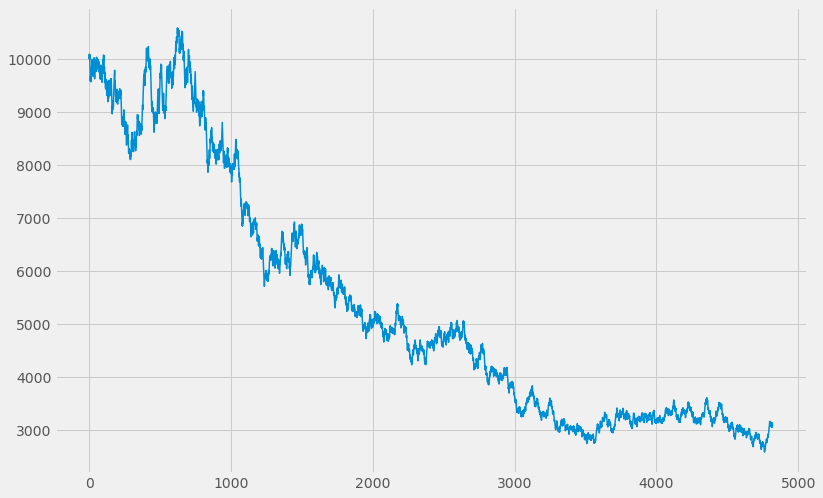

,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size
19276,-4.5,5,5.786142,1,1.0,1.0,10000.000000,10090.909091,100.000000
19277,-6.0,23,2.563208,0,1.0,0.0,10090.909091,9990.000000,100.909091
19278,-10.0,1,8.959846,0,0.0,1.0,9990.000000,10080.818182,99.900000
19279,-11.5,20,5.885853,0,1.0,0.0,10080.818182,9980.010000,100.808182
19280,-4.5,-4,5.319006,1,0.0,0.0,9980.010000,9880.209900,99.800100
...,...,...,...,...,...,...,...,...,...
24091,-1.5,6,1.745681,1,1.0,1.0,3082.111552,3110.130748,30.821116
24092,-2.5,-2,-23.505078,0,0.0,1.0,3110.130748,3138.404664,31.101307
24093,-5.0,10,2.028545,0,1.0,0.0,3138.404664,3107.020617,31.384047
24094,-8.0,11,4.722825,0,1.0,0.0,3107.020617,3075.950411,31.070206


In [508]:
simulate_bets(betting_results)

In [509]:
betting_results['bet_won'].value_counts()

1.0    2425
0.0    2300
0.5      95
Name: bet_won, dtype: int64

<AxesSubplot:ylabel='Frequency'>

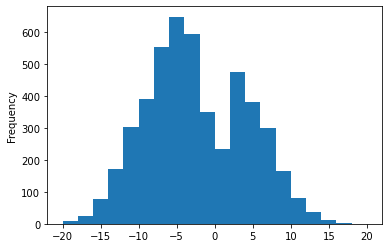

In [477]:
betting_results['spread'].plot(kind='hist', bins=20, range=(-20, 20))

In [448]:
X_train.shape

(19276, 138)

In [447]:
tscv = TimeSeriesSplit(n_splits=5)


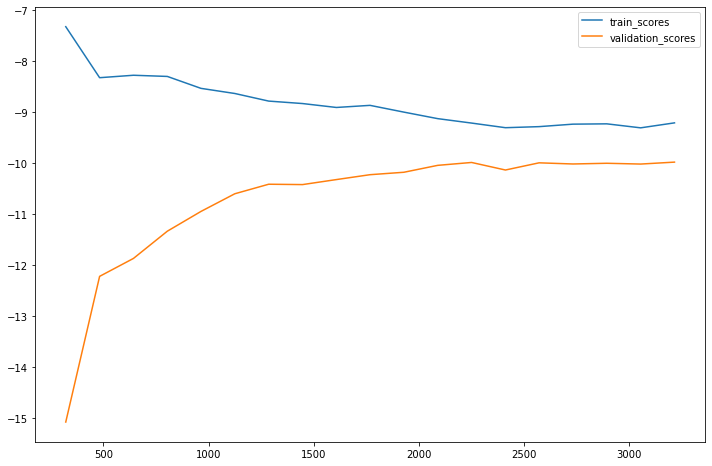

In [317]:
train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(normalize=True), X_train, point_diff_train,
                                                        train_sizes = np.linspace(0.1, 1, 19), cv = tscv,
                                                        scoring='neg_mean_absolute_error')

mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = valid_scores.mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_sizes, mean_train_scores, label='train_scores')
ax.plot(train_sizes, mean_val_scores, label='validation_scores')
plt.legend()
plt.show()

In [449]:
def select_features(estimator, X, y, min_features_to_select, cv_splits):
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    min_features_to_select = min_features_to_select

    rfecv = RFECV(estimator = LinearRegression(),
          step=2, cv = tscv,
         scoring='neg_mean_absolute_error', 
                  min_features_to_select= min_features_to_select,
         n_jobs = -1)

    rfecv.fit(X, y)

    print("Optimal Number of Features:", rfecv.n_features_)

    plt.figure()
    plt.xlabel("num_features")
    plt.ylabel("Cross validation MSE")
    plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
    plt.show()
        
    return rfecv
    

Optimal Number of Features: 138


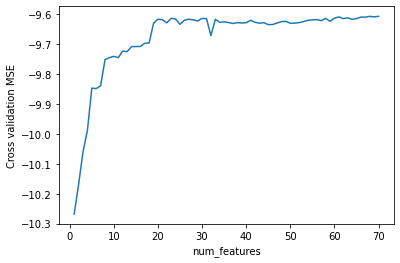

In [450]:
rfecv = select_features(LinearRegression(), X_train, point_diff_train, min_features_to_select=1, cv_splits=5)

In [453]:
selected_cols = features.iloc[:, rfecv.support_].columns

X_train_select = X_train[:, rfecv.support_]
X_test_select = X_test[:, rfecv.support_]

pd.DataFrame(X_train_select, columns=selected_cols)

,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_rest
0,-0.748977,-0.505279,-1.396412,-0.761323,-0.281057,-0.341124,1.661259,1.421236,0.279531,-1.463888,-1.057925,-1.028583,0.814625,-0.618465,1.225925,0.343945,-0.654529,0.508792,-0.467562,-0.294110,-0.907279,-1.076514,0.313564,0.596312,-0.831363,0.209120,-0.439959,-1.505246,1.009669,-0.949160,-0.568960,-0.881891,-0.383918,0.338312,-0.748977,0.505279,-0.282531,-0.317887,-0.990441,-1.229597,-0.441136,-0.104483,-0.725441,-0.808000,-1.073107,-0.434632,-0.837311,-0.475831,1.179273,0.804702,-1.147422,-0.508792,-0.907279,-1.076514,-0.467562,-0.294110,-0.313564,-0.596312,-0.701243,-0.209206,0.873363,-1.762358,0.805405,-0.942267,-0.019268,-0.215882,-0.605315,-1.569289,-0.256908,-0.746157,1.369370,0.442225,1.269058,-1.351687,-1.178552,1.428658,1.687976,0.812306,0.689227,1.121497,0.535260,1.738874,-0.972866,0.994338,1.263858,-0.348156,1.355907,-1.100515,-1.020692,-2.560906,-2.871977,1.054897,1.393113,0.884702,1.576898,1.176652,-0.720958,2.081950,-0.704026,1.298992,-0.976133,-1.096568,-1.224404,-0.746157,-1.369370,0.156174,1.023728,-1.774214,-1.236664,-1.028192,-0.394294,1.214645,0.119562,0.764531,-1.436993,0.940460,2.886337,2.733704,1.800441,-1.655746,-1.355907,-2.560906,-2.871977,-1.100515,-1.020692,-1.054897,-1.393113,1.002886,-1.576965,-1.314626,-0.727168,0.212059,1.104088,-0.377180,0.707349,-1.813698,-0.574687,-1.005328
1,-0.748977,-0.623864,-1.013147,-0.692433,-0.672556,-0.606310,1.389427,1.095236,-0.309204,-2.181035,-2.053343,-1.237674,0.638973,-1.003163,1.240536,0.287010,-0.855947,-0.152995,-0.646903,-0.661304,-0.459088,-0.580982,-0.163908,-0.087005,-0.676517,-0.106590,-0.386822,-1.718883,0.717405,-0.585937,-0.747270,-0.274514,-0.592176,-0.396451,-0.748977,0.623864,0.047323,-0.115688,-0.698792,-1.547714,-0.515488,-0.141149,-1.096202,-0.565217,-1.073107,-0.338969,-1.148188,-0.264414,1.334754,1.208653,-0.711007,0.152995,-0.459088,-0.580982,-0.646903,-0.661304,0.163908,0.087005,-0.593656,0.106505,0.782656,-0.899611,0.816255,-0.607809,-0.007411,0.096651,-0.624145,-0.502205,-0.256908,-0.746157,-1.633277,-2.534982,0.029251,-1.075428,-1.

In [456]:
lr.fit(X_train_select, point_diff_train)

y_preds = lr.predict(X_test_select)

r2_score = lr.score(X_test_select, point_diff_test)

linreg_mse_select = mean_squared_error(point_diff_test, y_preds)
linreg_mae_select = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", linreg_mse_select, "mean absolute error:", linreg_mae_select, "r2_score:", r2_score)

mean squared error: 176.67169466211152 mean absolute error: 10.441528574290318 r2_score: 0.10136011136483936


In [460]:
X_test
# bet_data_clean

array([[ 0.24855923,  0.91773698,  1.34696214, ...,  1.50634075,
         0.92530547,  0.0290855 ],
       [ 0.24855923,  0.91773698,  1.18558717, ...,  0.44996478,
         0.92530547, -1.00532809],
       [ 0.24855923,  0.91773698,  1.38730588, ...,  0.29905392,
         0.67530678,  1.06349909],
       ...,
       [ 0.24855923, -0.50527897,  0.62077479, ...,  3.6190927 ,
         2.92529498, -1.00532809],
       [ 0.24855923, -0.50527897,  0.58043105, ...,  2.10998417,
         2.92529498,  0.0290855 ],
       [ 0.24855923, -0.50527897,  0.21733738, ...,  4.75092411,
         0.92530547,  0.0290855 ]])

In [325]:
X_train.shape

(19271, 164)

In [353]:

ridge = RidgeCV(alphas = [0.1, 0.3, 0.5, 0.7, 1, 3, 10], cv=tscv, 
                scoring='neg_mean_squared_error')

ridge.fit(X_train, point_diff_train)

print("best_alpha: ", ridge.alpha_)
print("best_score: ", ridge.best_score_)
y_preds = ridge.predict(X_test)

ridge_mse = mean_squared_error(point_diff_test, y_preds)
ridge_mae = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", ridge_mse, "mean absolute error:", ridge_mae)


best_alpha:  10.0
best_score:  -147.48338088482112
mean squared error: 173.7289463547496 mean absolute error: 10.371806547688983


In [356]:

lasso_cv = LassoCV(cv=tscv)

lasso_cv.fit(X_train, point_diff_train)

print("best_alpha: ", lasso_cv.alpha_)

lasso = Lasso(alpha = lasso_cv.alpha_)

lasso.fit(X_train, point_diff_train)

y_preds = lasso.predict(X_test)

lasso_mse = mean_squared_error(point_diff_test, y_preds)
lasso_mae = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", lasso_mse, "mean absolute error:", lasso_mae)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.03315748774912, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.73371798050357, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.49391876423033, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: Convergenc

best_alpha:  0.060299990012402174
mean squared error: 173.1295015658412 mean absolute error: 10.366415142142827


In [362]:
en = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], max_iter=10000, cv=tscv)
en.fit(X_train, point_diff_train)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.781081585912034, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.86134070303524, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.73763998353388, tolerance: 99.96807456044813
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: Convergenc

ElasticNetCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=10000)

In [363]:
en.alpha_

0.32180291034093467

In [364]:
en.l1_ratio_

0.1

In [457]:
logr = LogisticRegression(solver='liblinear')

logr.fit(X_train, win_train)

score = logr.score(X_test, win_test)

print(score)


0.6360995850622406


In [268]:
win_pred = logr.predict(X_test)

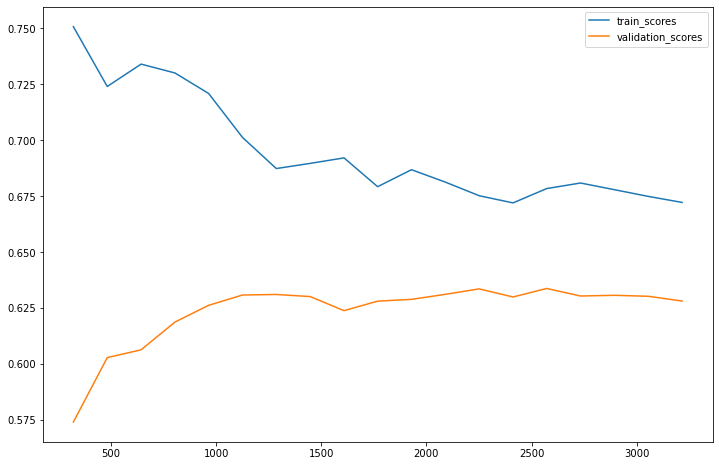

In [315]:
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(solver='liblinear'), X_train, win_train,
                                                        train_sizes = np.linspace(0.1, 1, 19), cv = tscv)

mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = valid_scores.mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_sizes, mean_train_scores, label='train_scores')
ax.plot(train_sizes, mean_val_scores, label='validation_scores')
plt.legend()
plt.show()

In [269]:
test = pd.DataFrame({'model_predictions':y_preds, 'actual_point_diff':point_diff_test, "model_win_prediction": win_pred, "actual_win_result": win_test})

test

,model_predictions,actual_point_diff,model_win_prediction,actual_win_result
19271,5.351108,7,1,1
19272,6.533092,9,1,1
19273,3.439585,5,1,1
19274,9.226603,5,1,1
19275,3.850905,12,1,1
...,...,...,...,...
24084,4.072028,6,1,1
24085,2.799928,-2,1,0
24086,2.218355,10,1,1
24087,6.796124,11,1,1


In [270]:
test['predict_home_winner'] = (test['model_predictions'] > 0).astype(int)

In [273]:
test['predict_home_winner'] == test['model_win_prediction']

19271    True
19272    True
19273    True
19274    True
19275    True
         ... 
24084    True
24085    True
24086    True
24087    True
24088    True
Length: 4818, dtype: bool

In [278]:
test['models_match'] = (test['predict_home_winner'] == test['model_win_prediction']).astype(int)
test.loc[test['models_match'] == 0]

,model_predictions,actual_point_diff,model_win_prediction,actual_win_result,predict_home_winner,models_match
19283,0.171256,12,0,1,1,0
19320,-0.710795,-5,1,0,0,0
19332,1.783913,9,0,1,1,0
19366,0.427932,6,0,1,1,0
19369,-0.884417,31,1,1,0,0
...,...,...,...,...,...,...
24019,-0.321605,19,1,1,0,0
24042,0.095976,-5,0,0,1,0
24069,-1.460965,15,1,1,0,0
24077,1.314890,28,0,1,1,0
